# EDA exploratory data analysis

In [132]:
library(DBI)
library(RSQLite)
library(dplyr)
library(ggplot2)
library(odbc)
library(Hmisc)
library(corrplot)
library(MESS)
library(ggExtra)
library(naniar)
library(mvoutlier)
library(MissMech)
library(mice)
library(MatchIt)
library(pastecs)
library(gridExtra)
library(tibble)
library(RColorBrewer)
library(VIM)
library(car)

ERROR: Error in library(MESS): there is no package called 'MESS'


In [3]:
con <- dbConnect(odbc(),
                Driver = "SQL Server",
                Server = "DESKTOP-9HVFU89\\RAFISQL",
                Database = "BoxOffice",
                Trusted_connection = "True")

In [34]:
ff <- dbReadTable(con, "movies_ff_v")

In [35]:
save(ff, file ="../data/BoxOffice_ff.RData")

In [36]:
load("../data/BoxOffice_ff.RData")

In [37]:
head(ff)

movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,14000000,en,6.575393,2015-02-20,93,Short,12314651,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40000000,en,8.248895,2004-08-06,113,Medium,95149435,1,0,...,0,0,0,0,0,0,3,0,0,1
3,3300000,en,64.299990,2014-10-10,105,Medium,13092000,1,1,...,0,1,0,0,0,0,2,0,0,0
4,1200000,hi,3.174936,2012-03-09,122,Large,16000000,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,ko,1.148070,2009-02-05,118,Medium,3923970,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8000000,en,0.743274,1987-08-06,83,Short,3261638,1,0,...,0,0,0,0,0,0,0,0,0,0


splitting to numeric and categorial data

In [119]:
#Continuous vars
cont_var <- c("revenue"
         ,"popularity"
         ,"runtime"
         ,"budget"
         ,"seasonality"
         ,"actor0_prev_revenue"
         ,"actor1_prev_revenue"
         ,"actor2_prev_revenue")

In [120]:
#categorial vars
cat_var <- c("revenue"
         ,"sw_lang_en"
         ,"sw_web_presence"
         ,"sw_has_poster"
         ,"sw_tagline"
         ,"high_release_month"
         ,"lang_US"
         ,"lang_FR"
         ,"lang_RU"
         ,"lang_ES"
         ,"lang_JA"
        ,"genre_adventure"
        ,"genre_fantasy"
        ,"genre_animation"
        ,"genre_drama"
        ,"genre_horror"
        ,"genre_action"
        ,"genre_comedy"
        ,"genre_history"
        ,"genre_western"
        ,"genre_thriller"
        ,"genre_crime"
        ,"genre_documentary"
        ,"genre_science_fiction"
        ,"genre_mystery"
        ,"genre_music"
        ,"genre_romance"
        ,"genre_family"
        ,"genre_war"
        ,"genre_foreign")

In [ ]:
#time vars with revenue
time_var <- c("revenue"
         ,"release_day"
         ,"release_month"
         ,"release_year"
         )

In [ ]:
#All the numeric 0/1 variables with y
numeric_var <- c("revenue"
        ,"keyword_cnt"
        ,"sw_collection"
        ,"producers_cnt"
        ,"countries_cnt"
        ,"actor0_movies_cnt"
        ,"actor0_movies_5y_cnt"
        ,"actor1_movies_cnt"
        ,"actor1_movies_5y_cnt"
        ,"actor2_movies_cnt"
        ,"actor2_movies_5y_cnt"
        ,"director_movies_cnt"
        ,"director_movies_5y_cnt"
        ,"depart_Art"
        ,"depart_Camera"
        ,"depart_Crew"
        ,"depart_Custom_Mkup"
        ,"depart_Directing"
        ,"depart_Editing"
        ,"depart_Lighting"
        ,"depart_Production"
        ,"depart_Sound"
        ,"depart_Visual_Effects"
        ,"depart_Writing"
        ,"depart_Art_female"
        ,"depart_Camera_female"
        ,"depart_Crew_female"
        ,"depart_Custom_Mkup_female"
        ,"depart_Directing_female"
        ,"depart_Editing_female"
        ,"depart_Lighting_female"
        ,"depart_Production_female"
        ,"depart_Sound_female"
        ,"depart_Visual_Effects_female"
        ,"depart_Writing_female")

# part 2 

In [111]:
summary(ff)

    movie_id        budget          original_language    popularity     
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  3.970  
 Median :3696   Median :  8000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   : 22666657                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :380000000                      Max.   :547.488  
                                                                        
 release_date          runtime      runtime_cat           revenue         
 Length:7375        Min.   :  0.0   Length:7375        Min.   :1.000e+00  
 Class :character   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Mode  :character   Median :104.0   Mode  :character   Median :1.693e+07  
                    Mean   :107.7                      Mean   :6.688e+07  
                    3rd Qu.:118.0        

In [121]:
exploreData <- function(data=data, y=NULL, rn=NULL, factorSize=10, dir="report", debug=FALSE, ...) {

  get_computer_type <- function(){
    # check if current R client is running on PC or on the server
    if (Sys.info()[1] == "Windows") {
      computer.type = "pc"
    } else if (Sys.info()[1] == "Linux") {
      computer.type = "server"
    }
    return(computer.type)
  }

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=T),sd=stats::sd(x,na.rm=T))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=T), "<br><u>Max date</u>:",max(x, na.rm=T) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    #pl <- stats::scatter.smooth(df$x,col=df$cl)
    pl <- tryCatch({
      stats::scatter.smooth(df$x,col=df$cl,xlab="index")
    }, warning = function(w) {
      n <- "warning!"
    }, error = function(e) {
      n <- "error!"
    }, finally = {
      graphics::plot(df$x ~ row.names(df),col=df$cl,xlab="index")
    })
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(ggplot2::aes(x=data[[x]], y=data[[y]]), method="loess") + ggplot2::xlab(x) + ggplot2::ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(ggplot2::aes(y=data[[x]], color=data[[y]])) + ggplot2::xlab(x) + ggplot2::ylab(y) + ggplot2::labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(unique(bp)), collapse=', ' )
    }
    imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")

  ################## Check for values for rn ##################
  if(!is.null(rn)) {
    if(length(rn)!=ncol(data)) {
      message("the value of the 'rn' argument was avoided because it does not have the same number of columns of the dataframe")
      rn <- NULL
    }
    xname <- rn
    names(xname) <- names(data)
  } else {
    xname <- NULL
  }

  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  if (get_computer_type()=="pc") {
    srcdir <- paste0(getwd(),"/",report)
  } else {
    #srcdir <- paste0("file_show?path=",getwd(),"/",report)
    srcdir <- paste0("/view/",getwd(),"/report")
  }
  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      background-color:#4C6F50;
      color: #fff;
      }
      .Row
      {
      display: table-row;
      }
      .Row:nth-child(even) {
        background-color: #56882433;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: Arial, Helvetica, sans-serif;
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)
  ln <- length(data)
  ii <- 0
  pb <- utils::txtProgressBar(min=0,max=ln,style=3)
  for(x in names(data)) {

    ## check if the value has at least more than one unique value...
    if(length(unique(data[[x]])) < 2) {
      message(paste("The variable",x,"has less than two unique values, so will not be included"))
    } else {

      if(debug==TRUE) {
        print(x)
      } else {
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)
      }

      html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b><p>",xname[x],"</p></div>")

      cat(html, file = myhtml, sep='\n', append=TRUE)
      #### initialize the first graph
      imgname = paste(fig,"/",x, "_1.png",sep="")
      imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
      ### send the data with the type to generate the correct graph..
      grDevices::png(imgname)
      drawGraphOne(x, data[[x]], data_types[x])
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # second, show the statistics
      html <- getStats(data[[x]],data_types[x])
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # third, determine the outliers
      imgname = paste(fig,"/",x, "_2.png",sep="")
      if(data_types[x]==1) {
        grDevices::png(imgname)
        getOutlierGraph(data[[x]])
        grDevices::dev.off()
        html <- getOutliersHtml(x,data[[x]],srcdir)
      } else {
        html <- "<div class='Cell'></div>"
      }
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # fourth, if y is assigned, make a corresponding plot
      if(is.null(y)==FALSE) {
        imgname = paste(fig,"/",x, "_3.png",sep="")
        imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
        #print(imgname)
        grDevices::png(imgname)
        ### scatter.smooth(data[[x]] ~ data[[y]])
        #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
        plot(getScatterGraph(data,x,y,data_types[y]))
        grDevices::dev.off()
        html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
        cat(html, file = myhtml, sep='\n', append=TRUE)
      }
      html <- paste("</div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      }
    }
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  if(.Platform$OS.type == "unix") {
    system(paste("start /b ", myhtml))
  } else {
    shell(paste("explorer ", gsub("/", "\\\\", myhtml) ), intern=TRUE)
  }
}

###################### END exploreData ###############

In [122]:
exploreData(data = ff, y = "revenue")

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4384 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4531 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.04"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.04"Warning message in 

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message:
"Removed 5310 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message:
"Removed 5534 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message:
"Removed 5621 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.115"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.115"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.7634e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.115"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.115"Warni

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.595"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.4923e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.595"Warni

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.165"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.165"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.2378e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.165"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.165"Warni

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.855"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.145"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  5.3293e-030"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 0.855"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.145"Warning

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.07"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.07"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.8888e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.07"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.07"Warning m

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.06"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0036"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.06"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf in foreig

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.26"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0676"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.26"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.26"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf in foreig

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 2"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 2"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.06"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.1175e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.06"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.06"Warning m

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."

  |===================================================================== |  99%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report\report.html' had status 1"

character(0)
attr(,"status")
[1] 1

In [85]:
num_ff<- Filter(is.numeric, ff)


In [87]:
res <- cor(num_ff,use="pairwise.complete.obs")
res

Warning message in cor(num_ff, use = "pairwise.complete.obs"):
"the standard deviation is zero"

,movie_id,budget,popularity,runtime,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
movie_id,1.000000e+00,0.0041642967,0.005173858,0.0009434593,0.001214268,0.001174848,0.0044600272,0.004872709,-0.008195807,0.006778693,...,-0.007189554,-0.003941264,0.001253388,-4.049993e-03,-0.012235944,-0.014247136,-0.0034277694,-0.014787023,0.013926136,-0.011770039
budget,4.164297e-03,1.0000000000,0.339388730,0.2164879358,0.752813373,0.190399464,0.2520384217,0.010093843,0.210015551,0.197089448,...,0.040635270,0.167460180,0.289641502,1.303634e-01,0.048701873,0.012807638,0.3059896680,0.111601108,0.091701832,0.056957463
popularity,5.173858e-03,0.3393887304,1.000000000,0.1122494375,0.461078462,0.119449944,0.1641094990,0.011544189,0.155693159,0.180578323,...,0.064341187,0.177099560,0.174299071,5.070417e-02,0.059520360,0.006528033,0.1787165897,0.077781853,0.035534199,0.035886995
runtime,9.434593e-04,0.2164879358,0.112249437,1.0000000000,0.216799905,-0.125600811,0.0317906518,0.009655723,0.003131133,0.137429144,...,-0.007659585,0.051709976,0.131967473,4.925078e-02,0.056225454,-0.009393959,0.0848086370,0.066062518,0.003993970,0.018338430
revenue,1.214268e-03,0.7528133727,0.461078462,0.2167999049,1.000000000,0.141707249,0.2630542517,0.008874882,0.179302534,0.186847451,...,0.030762556,0.129546911,0.255828534,9.557185e-02,0.005453434,0.038038950,0.2283043549,0.093542540,0.042701922,0.119148278
sw_lang_en,1.174848e-03,0.1903994638,0.119449944,-0.1256008106,0.141707249,1.000000000,0.0358338386,0.017001119,0.399816033,0.131497340,...,0.046203818,0.061462864,0.185577128,1.070781e-01,0.078637346,0.010576660,0.2419091140,0.071642335,0.027940415,0.052122042
sw_web_presence,4.460027e-03,0.2520384217,0.164109499,0.0317906518,0.263054252,0.035833839,1.0000000000,0.011308870,0.058632588,0.120796409,...,0.044412124,0.066090713,0.110793543,4.962399e-02,0.008767938,0.004510805,0.1642876224,0.086242512,0.050098899,0.039709632
sw_has_poster,4.872709e-03,0.0100938427,0.011544189,0.0096557233,0.008874882,0.017001119,0.0113088700,1.000000000,0.012644048,0.013870263,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sw_tagline,-8.195807e-03,0.2100155506,0.155693159,0.0031311327,0.179302534,0.399816033,0.0586325882,0.012644048,1.000000000,0.220826022,...,0.019762259,0.056877805,0.171782285,8.061299e-02,0.061203878,-0.013439134,0.1955807958,0.062637455,0.036848645,0.041318312
keyword_cnt,6.778693e-03,0.1970894481,0.180578323,0.1374291436,0.186847451,0.131497340,0.1207964088,0.013870263,0.220826022,1.000000000,...,0.040477946,0.114306199,0.187882111,9.741971e-02,0.085538841,0.019930871,0.2143332055,0.085455798,0.032810396,0.043342645


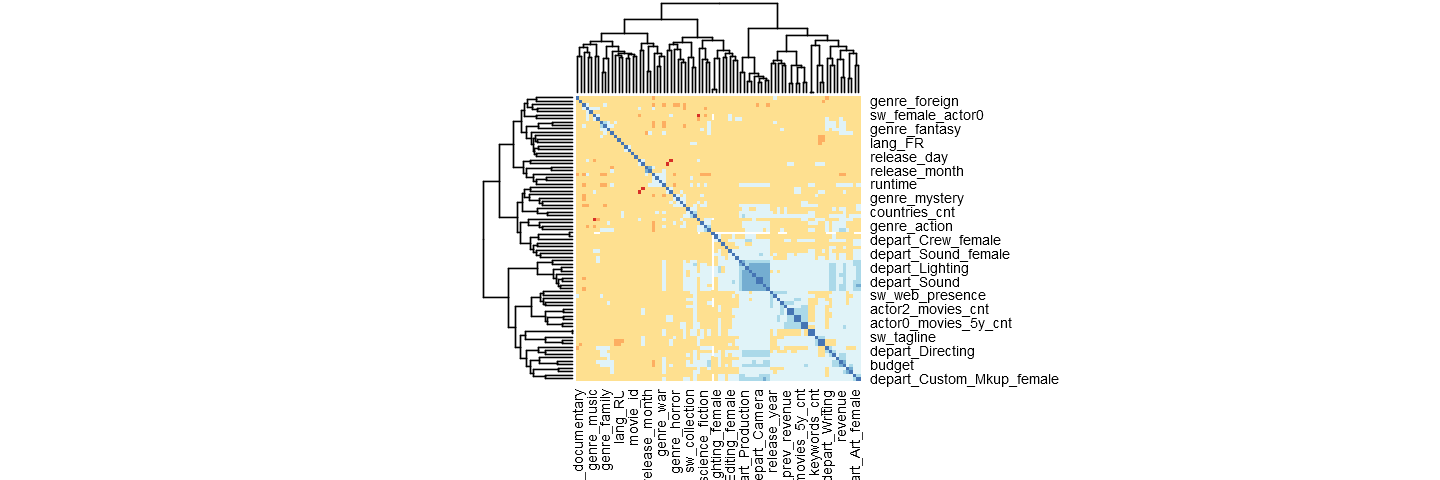

In [88]:
heatmap(res,symm = T,cexCol = 0.8, cexRow = 0.8, col=brewer.pal(n=8, name="RdYlBu"))

In [129]:
corrplot(res, type="upper", order="hclust", col=brewer.pal(n=8, name="RdYlBu"))

ERROR: Error in hclust(as.dist(1 - corr), method = hclust.method): NA/NaN/Inf in foreign function call (arg 10)


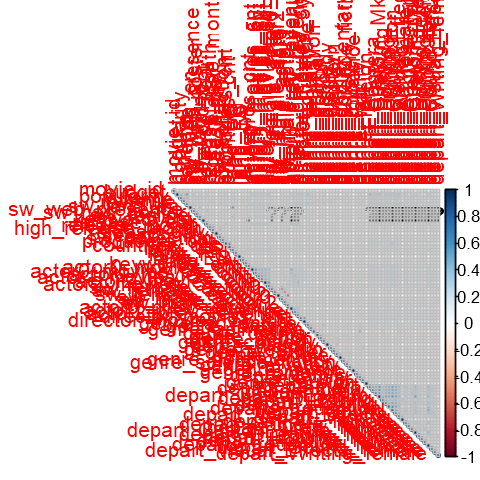

In [130]:
corrplot(res, type = "upper")

## part 2.4

describe revenue

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."

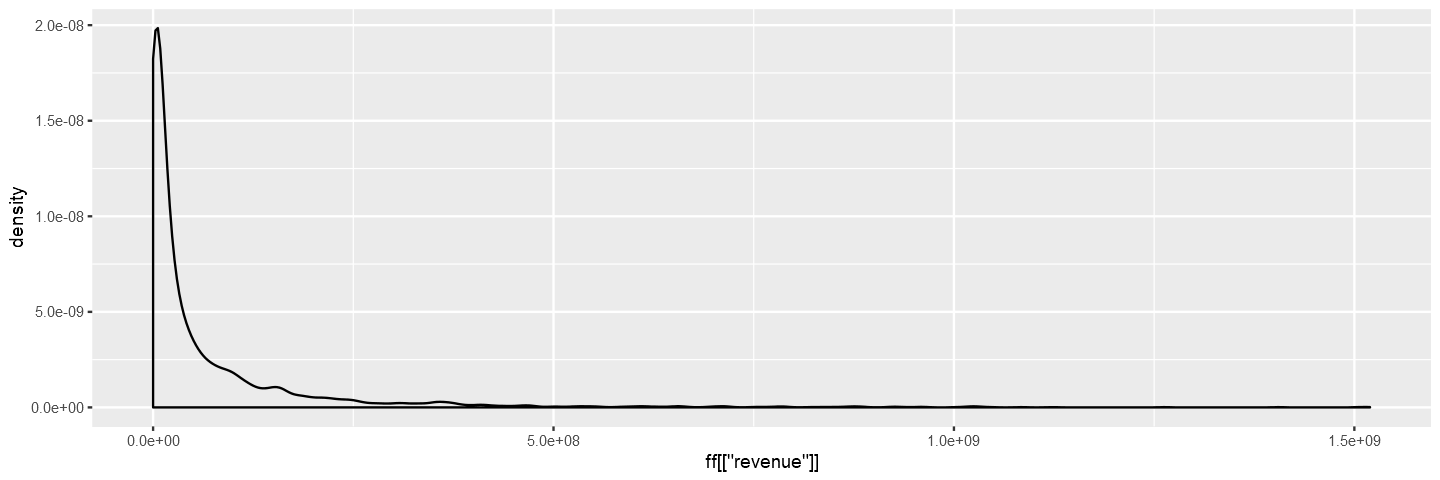

In [113]:
ggplot(data=ff) + geom_density(aes(ff[['revenue']]))

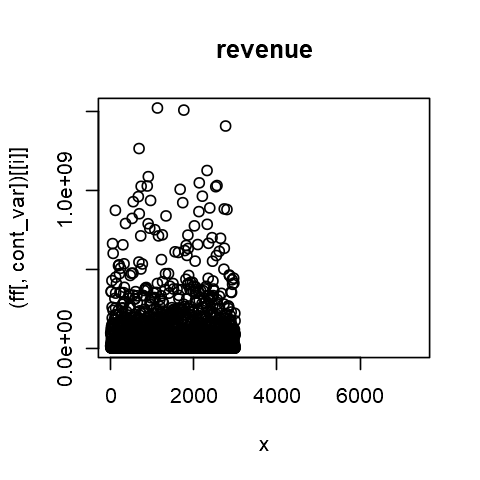

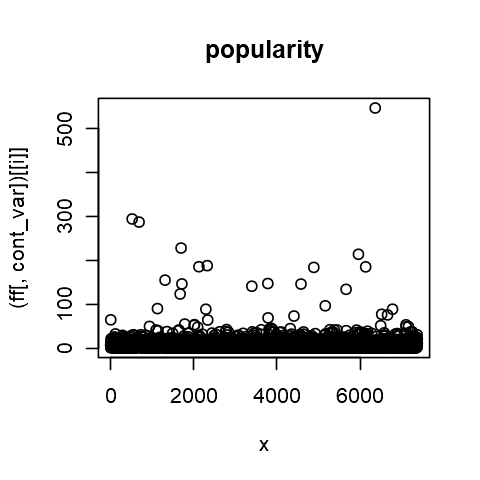

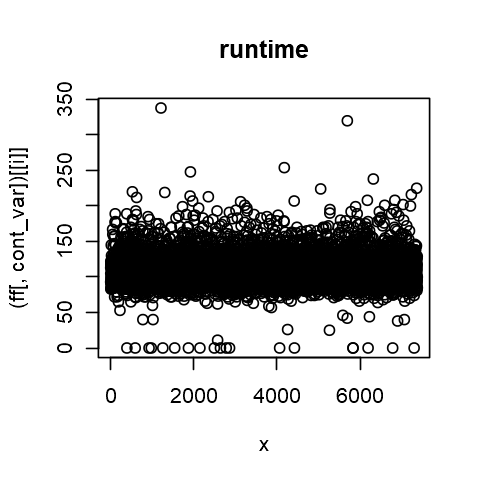

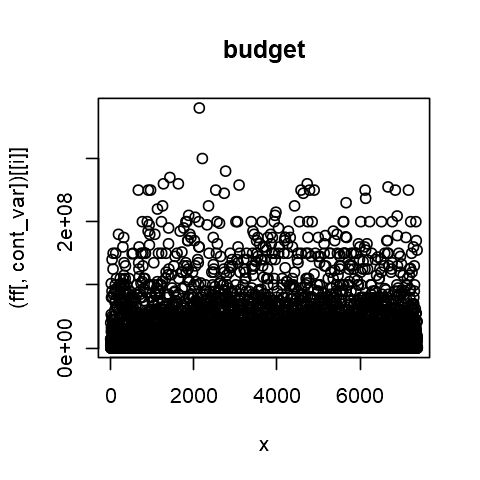

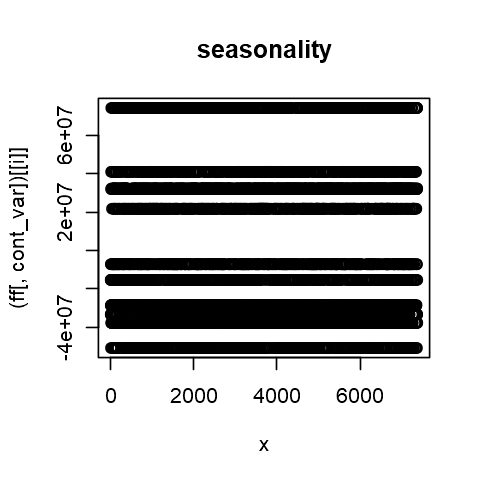

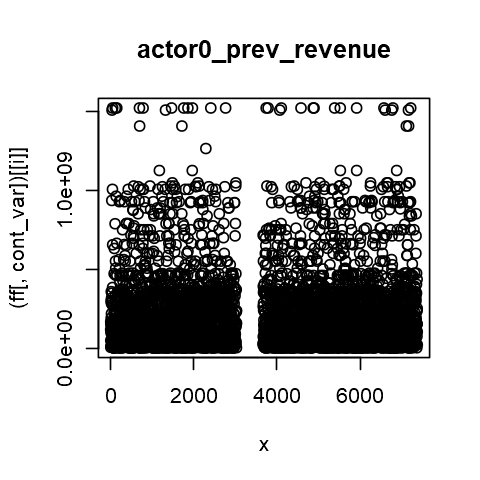

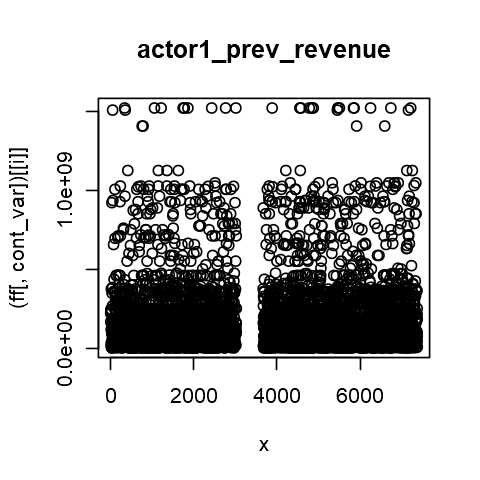

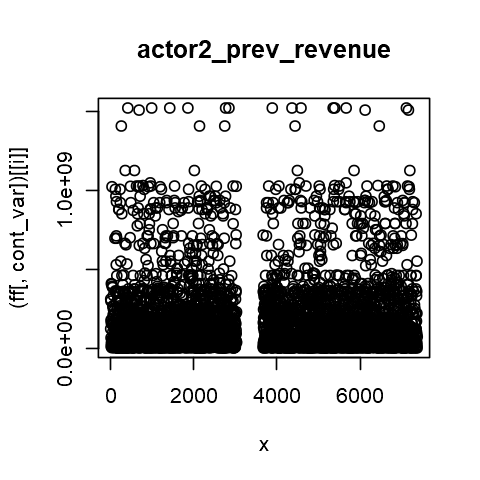

In [123]:
#graph for outliers
options(repr.plot.width = 4, repr.plot.height = 4)
x <- 1:nrow(ff[,cont_var])
for(i in names(ff[,cont_var])) {
    plot((ff[,cont_var])[[i]] ~ x, main=i)
}

# # code for getting missing valuues

In [114]:
getMissingness <- function(data, getRows=FALSE) {
  desc <- na_count <- na_cnt <- rn <- pred <- dc <- NULL
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==T,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of mossings and leave only those with missings
  cnt <- cnt %>%
    dplyr::arrange(desc(na_count)) %>%
    dplyr::filter(na_count>0)
  totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::summarise(n=n())
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- seq_len(nrow(data))
    idx <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::select(rn)
  }
  print(list(head(cnt,n=10), msg))
  return(list(missingness=cnt, message=msg, rows=idx$rn))
}

In [115]:
getMissingness(ff)

[[1]]
                   var na_count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3423 46.4
3  actor1_prev_revenue     3201 43.4
4  actor0_prev_revenue     2752 37.3
5     sw_female_actor0      934 12.7
6       sw_male_actor0      934 12.7
7     sw_female_actor2      788 10.7
8       sw_male_actor2      788 10.7
9     sw_female_actor1      782 10.6
10      sw_male_actor1      782 10.6

[[2]]
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."



var,na_count,rate
<fct>,<dbl>,<dbl>
revenue,4382,59.4
actor2_prev_revenue,3423,46.4
actor1_prev_revenue,3201,43.4
actor0_prev_revenue,2752,37.3
sw_female_actor0,934,12.7
sw_male_actor0,934,12.7
sw_female_actor2,788,10.7
sw_male_actor2,788,10.7
sw_female_actor1,782,10.6


missing natrix

In [124]:
ff.na <- ff
for(i in names(ff)) {
    ff.na[,i] <- ifelse(is.na(ff.na[,i])==T,1,0)
}

In [125]:
head(ff.na)

movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Warning message in brewer.pal(n = ncol(ff), name = "RdYlBu"):
"n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
"

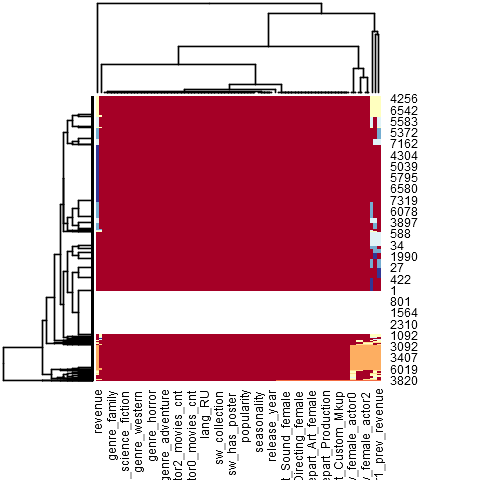

In [127]:
heatmap(as.matrix(ff.na),cexCol = 0.7, cexRow = 0.7, col=brewer.pal(n=ncol(ff), name="RdYlBu"))

# part 3 data Cleansing

[1] 102000000  80000000  90000000 140000000  80000000 125000000 150000000
  [8]  85000000  75000000 100000000  93000000  90000000 150000000 110000000
 [15]  90000000  82500000 180000000  85000000  75000000 100000000 110000000
 [22] 102000000  98000000 160000000 100000000 100000000 108000000 175000000
 [29] 115000000  85000000 135000000  90000000 100000000  75000000 110000000
 [36] 130000000  75000000  90000000 100000000  74500000  75000000  87000000
 [43] 110000000  85000000  80000000  90000000  80000000 149000000  78146652
 [50]  75000000 150000000  79000000  75000000  80000000  85000000 100000000
 [57] 250000000 135000000 125000000 160000000 113000000  85000000  90000000
 [64]  80000000 103000000 150000000  80000000 200000000 105000000 130000000
 [71] 150000000  94000000 110000000  75000000 110000000 150000000 150000000
 [78]  88000000 200000000 185000000 100000000 250000000 195000000 163000000
 [85] 180000000 100000000 250000000  80000000  80000000  80000000  73000000
 [92]  75000000 135000000 100000000 180000000  85000000  85000000  95000000
 [99] 105000000 220000000  75000000 100000000 150000000  90000000  80000000
[106]  85000000  90000000 100000000 200000000 100000000 150000000 105000000
[113] 225000000 260000000 110000000 150000000 120000000  80000000  85000000
[120] 116000000 165000000 190000000  85000000 125000000 270000000 116000000
[127]  95000000 130000000  88000000  90000000 145000000  75000000  80000000
[134] 150000000  73000000  85000000 260000000 110000000 185000000 120000000
[141] 152000000 120000000  94000000 120000000 130000000 190000000  97000000
[148] 135000000 200000000 120000000 200000000 130000000 170000000 170000000
[155] 125000000 108000000  80000000 210000000 105000000  80000000 180000000
[162] 175000000  83000000  85000000 120000000  80000000  80000000 100000000
[169] 170000000 207000000 130000000  75000000 105000000  75000000 140000000
[176] 135000000 100000000 160000000 200000000 160000000 380000000 103000000
[183]  80000000 300000000  85000000  90000000 100000000  75000000  90000000
[190]  85000000 195000000  75000000  79000000 225000000 150000000  90000000
[197]  80000000 120000000 100000000  85000000 175000000 132000000 125000000
[204] 120000000  97250400  90000000 250000000  75000000  80000000 150000000
[211]  80000000 200000000 165000000  90000000  80000000 197471676 102000000
[218]  80000000  75000000 105000000 145000000  85000000 100000000 100000000
[225] 125000000 245000000 120000000  92000000  90000000 280000000  82000000
[232]  80000000 115000000 100000000  80000000  95000000  75000000 120000000
[239] 130000000 150000000 127500000  75000000  80000000  87000000 140000000
[246]  75000000  90000000 130000000  80000000  90000000 100000000 200000000
[253] 140000000 200000000 135000000 160000000  75000000 258000000  75000000
[260]  80000000 150000000 120000000  92620000  80000000 100000000 140000000
[267] 125000000  80000000  78000000 110000000 120000000 110000000  90000000
[274] 150000000 140000000  75000000  90000000 200000000  95000000  85000000
[281] 130000000 125000000 150000000 185000000 115000000  73000000 180000000
[288] 130000000  85000000 137000000  82000000 170000000 150000000  80000000
[295] 175000000 145000000  90000000  80000000  92000000 165000000  79000000
[302] 140000000  75000000  93000000  79000000 140000000 200000000  80000000
[309] 130000000  75000000 160000000 112000000  85000000 140000000  80000000
[316]  75000000  85000000 160000000 155000000  75000000 110000000 175000000
[323] 100000000 125000000 110000000  80000000 180000000 165000000 140000000
[330]  73000000 150000000 175000000  75000000 100000000 110000000 200000000
[337] 150000000 210000000 140000000 215000000  80341000  90000000 190000000
[344] 150000000 160000000  75000000  85000000 100000000 110000000  80000000
[351] 150000000  80000000 170000000 127000000 175000000 175000000 105000000
[358] 105000000  80000000 165000000 150000000 185000000  98000000 175000000
[365] 100000000  78000000 160000000 110000000  780

[1] 7.3e+07

budget.out
   0    1 
6751  624 

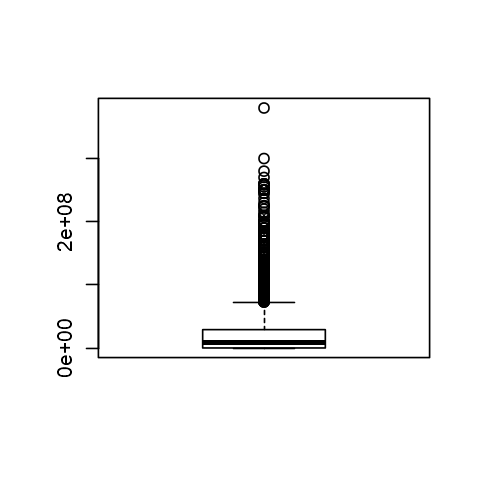

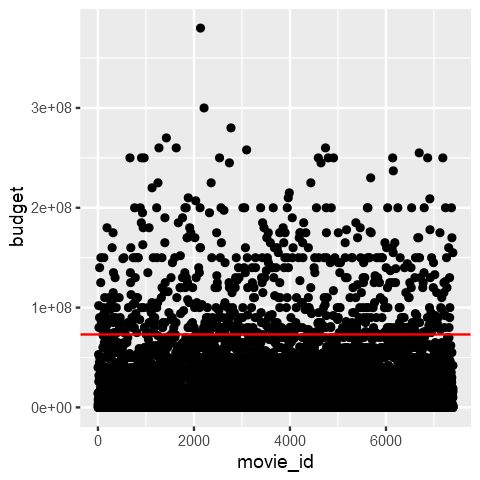

Warning message:
"Removed 4382 rows containing missing values (geom_point)."Warning message:
"Removed 4631 rows containing missing values (geom_point)."

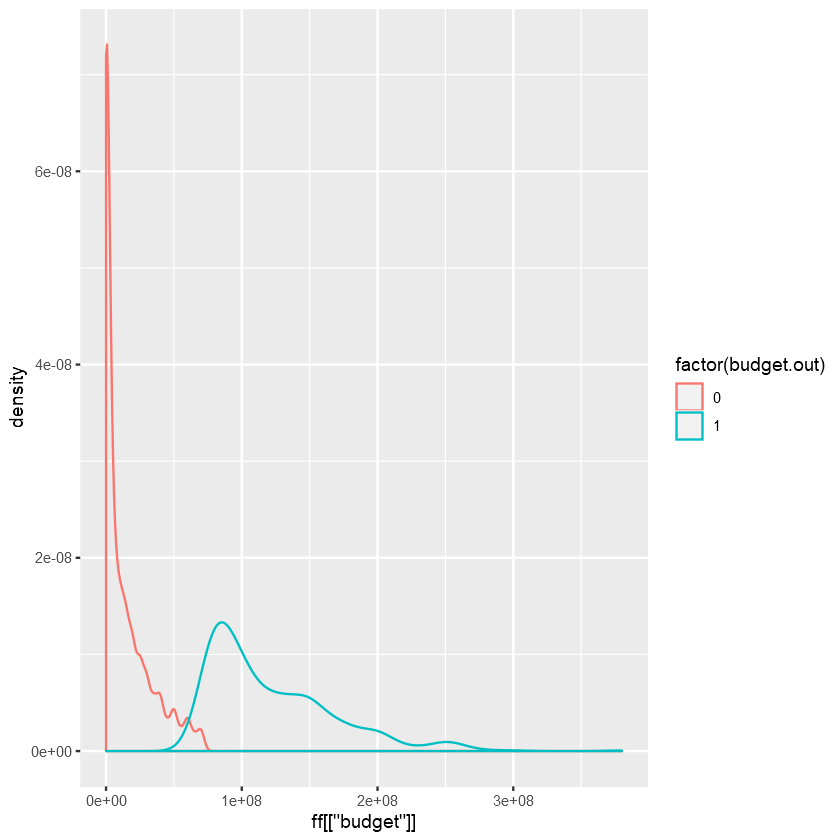

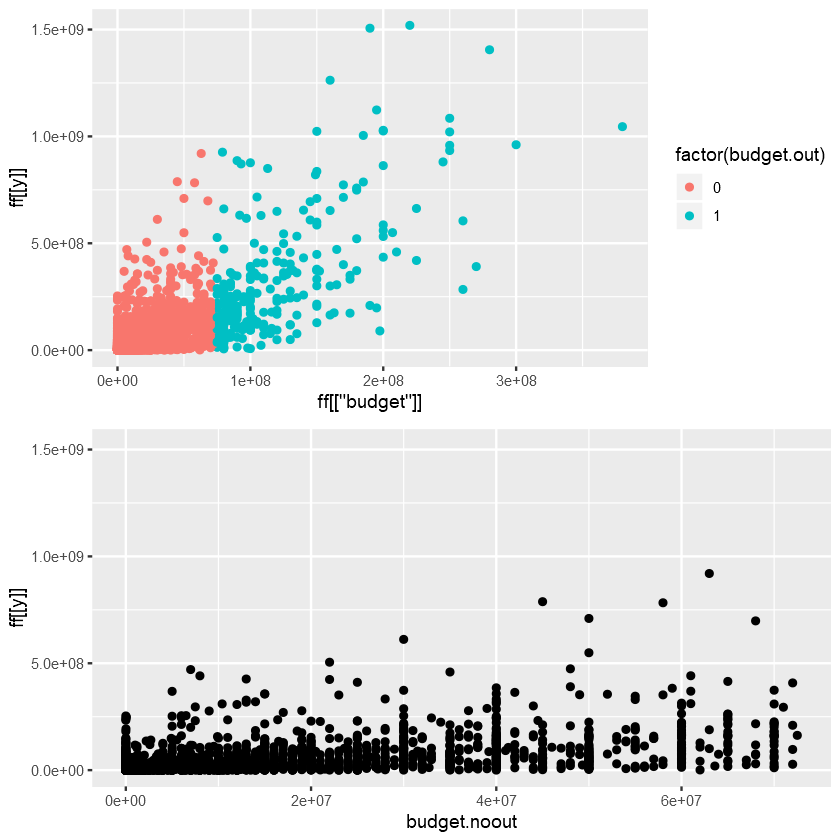

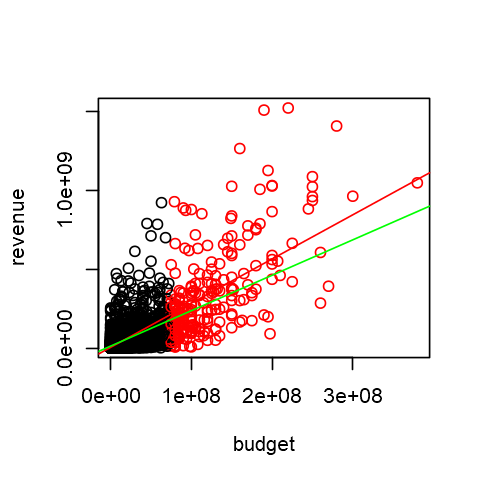

In [140]:
options(repr.plot.width = 4, repr.plot.height = 4)
budget.out<-boxplot(ff$budget)
budget.out$out
min(budget.out$out)

budget.out <- ifelse(ff[["budget"]] >= min(budget.out$out),1,0)
table(budget.out)
ggplot(data=ff) +
   geom_point(aes(x=movie_id, y=budget))+
   geom_hline(yintercept = 7.3e+07,color="red")

y<- 'revenue'

#Creating a new var without the outliers
budget.noout <- ff[['budget']]
budget.noout <- ifelse(budget.out==1,NA,budget.noout)

#ploting the graph with the outliers comparing the data without the outliers
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot() + geom_density(aes(ff[["budget"]], group=factor(budget.out), color=factor(budget.out)))

#ploting the geom_point graph with the outliers comparing the data without the outliers
p1 <- ggplot() + geom_point(aes(x=ff[['budget']], y=ff[[y]], color=factor(budget.out)))# this plot with the outliers
p2 <- ggplot() + geom_point(aes(x=budget.noout, y=ff[[y]]))# without the oulieur
grid.arrange(p1, p2, nrow = 2)

#Runing the models in order to see if there is a different between the plot
mod1 <- lm(ff[[y]] ~ ff[['budget']])# this is a linear model for the data with the outliers 
mod2 <- lm(ff[[y]] ~ budget.noout)# this is a linear model for the data without the outliers

options(repr.plot.width = 4, repr.plot.height = 4)#graph to coompare the 2 models
plot(ff[['budget']], ff[[y]], col=factor(budget.out),xlab="budget",ylab=y)
abline(mod1, col="red") 
abline(mod2, col="green")

In [145]:

min(budget.out$out)

[1] 7.3e+07

3.2 missing value

In [146]:
## save the original table into another table and put the dataset after the outlier treatment into df
df.orig <- df
df <- df.noout

ERROR: Error in eval(expr, envir, enclos): object 'df.noout' not found


In [147]:
## remade the missing matrix to include the new missing values generated by the outliers treatment
df.na <- ff
for(i in names(ff)) {
    df.na[,i] <- ifelse(is.na(df.na[,i])==T,1,0)
}

In [148]:
head(df.na)

movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
nm <- cont_var
## iterate through the variables
for(i in 1:length(nm)) {
    for(j in 1:length(nm)) {
        ## check if i and j are the same
        if(i!=j) {
            ## check if the variable is numeric and has missing values
            if(is.numeric(ff[[i]])==TRUE & sum(df.na[[i]])>0) {
                ## if the j variable is a factor print a differential distribution plot
                if(is.factor(ff[[j]])) {
                    print(paste(nm[i],"by",nm[j]))
                    p1 <- ggplot() + geom_density(aes(ff[[i]],group=ff[[j]],color=ff[[j]]))
                    plot(p1)
                }
            }
        }
    }
}


In [151]:
missres <- data.frame(variable=NULL,mechanism=NULL,treatment=NULL)
missres

<0 x 0 matrix>